# International Dragon Boat Races - Exploratory Data Analysis

## Dragon Boat: 

Dragon Boat is a canoe-sport whose origins go back 2.500 years in ancient China. It began as a modern sport in 1976 in Hong Kong and has since become a very popular sport all around the World. It is practised in standard DB20 boats or small DB10 boats, each with a crew of 20 or 10 paddlers plus a drum and a steer-person. More details about crew composition, categories and other aspects of official International Championships:
https://en.wikipedia.org/wiki/International_Dragon_Boat_Federation


Despite being a National sport in many countries and gaining increased popularity in many other, there are little data resources and analysis available so far.

The aim of this project is to **answer some questions about the state of the art of Dragon Boat in International Races**. Questions such as: 

- *Is Dragon Boat a private club for only a few countries dominating the scene? Are there any challengers?*
- *Do all countries perform equally in all distances and cathegories?*
- *Do some countries have more explosive paddlers Vs other long distance ones?*
- *How did countries' performances evolve in the last years?*
- *How do countries perform in different kind of events (International Vs Regional)?*

For that purpose, we will **structure the project in the following steps**:
- **Data Collection**: Identification of Data sources, addition on new Data.
- **Data Cleaning**: Ensuring a common and clean data structure.
- **Data Analysis**: Based on the available data, answer some questions about How Dragon Boat teams are performing in races around the Globe.

In [1]:
# Import libraries

import pandas as pd
import numpy as np

import folium

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# 1. Data Collection:

The main problem in Dragon Boat is the reduced amount of available data. Therefore, the first step of the project was to identify a reliable and sufficiently rich source of Data. This was possible by accessing the data available in the International Dragon Boat Federation (IDBF) website.

- Data source: https://idbfchamps.org/2019tha


Thanks to the work of IDBF IT Team, there is access to data of the results of International Dragon Boat Events. These data will be the base for the first steps of the analysis. Data collection was possible by scrapping and just like I would do in the boat, I got help from my team mate Pablo, who provided me with a wonderful code that was able to scrap the web page and get the data in a .csv file.

**NOTE**: When integrating all competitions in one single data set, an additional column was added in order to identify each event.

In [2]:
# Importing data

data = pd.read_csv('WDBRC_data.csv', sep=';')
data.head()


,venue,# in dst.,# in filtered dst.,result,crew,boat,distance,age,gender,race no,lane,stage,all comers,comment
0,Thailand_2019,1.0,1.0,39.251,China,20,200,premier,open,275,3,grand final,NaN,NaN
1,Thailand_2019,2.0,2.0,40.330,Thailand,20,200,premier,open,275,4,grand final,NaN,NaN
2,Thailand_2019,3.0,3.0,41.047,China,20,200,premier,open,221,3,heat 1,NaN,NaN
3,Thailand_2019,4.0,4.0,41.253,Canada,20,200,premier,open,275,2,grand final,NaN,NaN
4,Thailand_2019,5.0,5.0,41.648,Thailand,20,200,premier,open,222,3,heat 2,NaN,NaN


### Original Data Structure:

- `# in dst.`: number reference in the original dataset.
- `# in filtered dst.`:  number reference in filtered dataset.
- `result`: race time for that particular crew in that particular event.
- `crew`: racing team (either country of the National Team, or Club Crew).
- `boat`: standard boat (20 paddlers), small boat (10 paddlers).
- `distance`: race distance (200 m., 500 m., 1000 m., 2000 m.).
- `age`: racing cathegory of the crew (premier, senior A, senior B, senior C, u24, junior A, junior B, PD-1, PD-2)
- `gender`: crew gender (open, women or mixed crew).
- `race no`: reference number of one particular race in one particular event.
- `lane`: racing lane for that boat in that particular race.
- `stage`: stage of the championchip in which that race took place (heat, repechage, semi final, tail race, minor final, grand final, final round).
- `all comers`: (tbc).
- `comment`: any comments related to that race and crew (any penalties or other comments).

In [3]:
# Get the first big numbes of the data set

print('The dataframe includes {} observations, which represent the result of each crew in any of the events of a Championship.'.format(len(data)))

print('There are in total {} events'.format(data['venue'].nunique()))

The dataframe includes 7126 observations, which represent the result of each crew in any of the events of a Championship.
There are in total 6 events


# 2. Data Cleaning:

Once we ingested the datasets, we have to do some data wrangling in order to pursue further analysis. Besides of renaming some columns to make it easier to work with, data wrangling at this stage included:

**Treating formats**:
- **Trimming column `crew`**: get rid of any space
- **Formating column `result`**: in order to have all data in the column in the same format mm:ss.sss we need to apply some formating which will later on allow to compute the time result of each crew (i.e. the total seconds)

**Dropping columns**: the position in original dataset and filtered dataset.

**Adding new columns**: 

- **Adding a column `venue`** to identify data for each event
- **Create a calculated column `speed`** which will be our main variable to analyse performance.

**Changing columns**: arranging column names for country and crew.

In [4]:
# Renaming columns:

data.rename(columns={'race no': 'race_number',
                     'lane': 'lane_number',
                     'age': 'age_category',
                     'boat': 'boat_type',
                     'crew': 'country'}, errors="raise", inplace=True)

# Dropping order and Nan columns:

data.drop(['# in dst.', '# in filtered dst.', 'all comers', 'comment'], axis=1, inplace=True)

**First, we trim the `crew` column**

In [5]:
# Trimming 'crew' column

data['country'] = data['country'].str.strip()

**Now, let's deal with `result` column**

In [6]:
# Formating 'result' column. It is a :

data['new_result'] = data['result'].str.pad(9, side='left', fillchar='-')
data['new_result'] = data['new_result'].str.replace('---','00:')
data['new_result'] = data['new_result'].str.replace('-','0')
data['new_result'] = data['new_result'].str.replace('.',':')
data['new_result']

0       00:39:251
1       00:40:330
2       00:41:047
3       00:41:253
4       00:41:648
          ...    
7121    10:35:270
7122    10:38:330
7123    11:38:650
7124    11:44:270
7125    12:24:400
Name: new_result, Length: 7126, dtype: object

In [7]:
# Computing the total seconds in each crew's race result

data['race_result'] = data['new_result'].apply(str)
time = data['race_result'].str.split(':', n = 3, expand = True)
data['race_result'] = pd.to_numeric(time[0])*60000 + pd.to_numeric(time[1])*1000 + pd.to_numeric(time[2])
data['race_result'].head()

0    39251
1    40330
2    41047
3    41253
4    41648
Name: race_result, dtype: int64

**Getting 'speed' variable**

In [8]:
# Let's create a variable 'speed' from the variables distance and race_result --- m/s

data['speed'] = data['distance'] / (data['race_result']/1000)

#### Formatting boat type and distance and checking that all data is in the right format

In [9]:
data['boat_type'] = data['boat_type'].astype(str)
data['distance'] = data['distance'].astype(str)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7126 entries, 0 to 7125
Data columns (total 13 columns):
venue           7126 non-null object
result          7126 non-null object
country         7126 non-null object
boat_type       7126 non-null object
distance        7126 non-null object
age_category    7126 non-null object
gender          7126 non-null object
race_number     7126 non-null object
lane_number     7126 non-null int64
stage           7126 non-null object
new_result      7126 non-null object
race_result     7126 non-null int64
speed           7126 non-null float64
dtypes: float64(1), int64(2), object(10)
memory usage: 723.9+ KB


In [10]:
data.drop(['result', 'race_result'], axis=1, inplace=True)

# 3. Data Analysis

## Some preliminary exploration

There are some categorical values which will probably be the ones to carry out analysis related to performance (in terms of speed). Those are related to:

- **The race**: `distance` and `stage`
- **The crews**: `age_category` and `gender`

In [11]:
print('Race Distances:', data['distance'].unique())
print('Race Stages:', data['stage'].unique())
print('Age Categories:', data['age_category'].unique())
print('Genders:', data['gender'].unique())

Race Distances: ['200' '500' '1000' '2000']
Race Stages: ['grand final' 'heat 1' 'heat 2' 'round 2' 'round 1' 'minor final'
 'semi 2' 'semi 1' 'semi 3' 'heat 3' 'heat 4' 'plate final' 'rep 1'
 'rep 2' 'tail 2' 'tail 1' 'round 3' 'final' 'final 1' 'semi' 'round 0'
 'tail' 'round']
Age Categories: ['premier' 'senior A' 'u24' 'junior A' 'senior B' 'senior C' 'junior B'
 'PD-1' 'PD-2' 'u23']
Genders: ['open' 'mixed' 'women']


## Who are the fastest Dragons?


**Which was the fastest crew of all races in all International Championships?**


In [12]:
speed_rank = data.groupby('country').max()['speed'].sort_values(ascending=False)
speed_rank.head()

country
China            5.095412
Philippines      4.997252
Thailand         4.959088
Canada           4.848132
United States    4.745972
Name: speed, dtype: float64

In [13]:
# The fastest crew:

data.sort_values('speed', ascending=False).head(1)

,venue,country,boat_type,distance,age_category,gender,race_number,lane_number,stage,new_result,speed
0,Thailand_2019,China,20,200,premier,open,275,3,grand final,00:39:251,5.095412


In [14]:
# The slowest crew:

data.sort_values('speed', ascending=False).tail(1)

,venue,country,boat_type,distance,age_category,gender,race_number,lane_number,stage,new_result,speed
1829,Thailand_2019,India,10,2000,premier,women,15,1,final,14:52:816,2.240103


**Tadaaaa!**

Ok, that's fine: **China has the fastest National Team crew** (big deal....)

But let's see what's happening with the rest of the World:

- Which countries take part in National Championships?
- Which countries are the fastests in the Dragon Boat International scene?

**Let's visualize it in a Map: Top Speed Dragon Boat World Map**:

In [15]:
# First, we need to rename some countries in order to match the list of countries used by Folium

data['country'].replace({'United States': 'United States of America',
                          'Chinese Taipei': 'Taiwan',
                          'Serbia': 'Republic of Serbia',
                          'Korea': 'South Korea',
                          'Slovak Republic': 'Slovakia',}, inplace=True)

In [16]:
# Data preparation: we want a df with country info and max speed:

grouped_countries = data.groupby('country')
maximums = grouped_countries['speed'].max()
maximums = maximums.reset_index()
maximums = maximums.sort_values('speed', ascending=False)


In [19]:
#Setting up the world countries data URL

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'

#Creating a base map

m = folium.Map(location=[25, 0], zoom_start=1.5)

#Adding the Choropleth layer onto our base map

folium.Choropleth(
    geo_data=country_shapes,
    name='choropleth',
    data=maximums,
    columns=['country', 'speed'],
    key_on='feature.properties.name',
    fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
    nan_fill_color='white',
    legend_name='Max Speed performed by crews in any event'
).add_to(m)

folium.LayerControl().add_to(m)
m

### Issues I encountered when plotting the Map:

- I thought I needed country coordinates to be in my dataframe. No need, total loss of time
- However... suddenly United Stated was not in the Map! This is because the names of the countries in my dataframe didn't match those in the json file. That happened for the US and some other countries. I was able to rename most of them, but some territories are not even in the json.

"Lost" crews are:
- Macau
- Hong Kong
- IDBF: This is the International Dragon Boat Association. Maybe some countries don't have a National Team and their paddlers need to race under an International flag? Need to digg in...


## What about the Top crews?

In [31]:
data.sort_values(by='speed', ascending=False).head(20)

,venue,country,boat_type,distance,age_category,gender,race_number,lane_number,stage,new_result,speed
0,Thailand_2019,China,20,200,premier,open,275,3,grand final,00:39:251,5.095412
1830,China_2017,China,20,200,premier,open,155,3,grand final,00:39:655,5.043500
6061,Czech_2009,Philippines,20,200,premier,open,139,3,grand final,00:40:022,4.997252
6062,Czech_2009,China,20,200,premier,open,139,5,grand final,00:40:125,4.984424
1,Thailand_2019,Thailand,20,200,premier,open,275,4,grand final,00:40:330,4.959088
1831,China_2017,China,20,200,premier,open,117,3,heat 1,00:40:496,4.938759
6063,Czech_2009,Philippines,20,200,premier,open,127,3,semi 1,00:40:683,4.916058
6064,Czech_2009,China,20,200,premier,open,127,4,semi 1,00:40:904,4.889497
2,Thailand_2019,China,20,200,premier,open,221,3,heat 1,00:41:047,4.872463
2741,Canada_2015,China,20,200,premier,open,195,3,grand final,00:41:159,4.859205


From a preliminary view over the Top-16 fastest crews we can draw some quick conclusions, and get some further questions:

- The **fastest crews compete in 200m races**. That's a very explosive kind of race (my favorite) and where the top speed is developed
- We could expect that the most recent races will be the fastest ones, but **some of the top speeds were performed 10 years ago**.
- So far, **only China was able to paddle over 5 m/sec**, always in Finals and Open Premier Category
- However, some top speed were performed in **classification rounds**
- **Premier Open (mostly men) Category in 200m** is the fastest one (i.e. no age restrictions and no crew composition restrictions).

- **Watchout for Canadian Seniors!!** Forties are the new thirties! Canadian Senior A (+40) Open crew broke the clock in Thailand.

## How are speeds distributed?

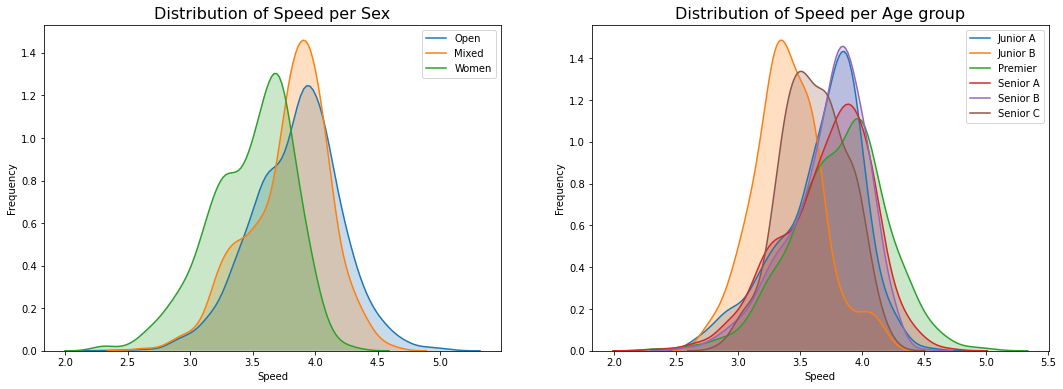

In [32]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.kdeplot(data.speed[data.gender=='open'], label='Open', shade=True)
sns.kdeplot(data.speed[data.gender=='mixed'], label='Mixed', shade=True)
sns.kdeplot(data.speed[data.gender=='women'], label='Women', shade=True)
plt.title('Distribution of Speed per Sex', fontsize=16)
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.subplot(1,2,2)
sns.kdeplot(data.speed[data.age_category=='junior A'], label='Junior A', shade=True)
sns.kdeplot(data.speed[data.age_category=='junior B'], label='Junior B', shade=True)
sns.kdeplot(data.speed[data.age_category=='premier'], label='Premier', shade=True)
sns.kdeplot(data.speed[data.age_category=='senior A'], label='Senior A', shade=True)
sns.kdeplot(data.speed[data.age_category=='senior B'], label='Senior B', shade=True)
sns.kdeplot(data.speed[data.age_category=='senior C'], label='Senior C', shade=True)
plt.title('Distribution of Speed per Age group', fontsize=16)
plt.xlabel('Speed')
plt.ylabel('Frequency');

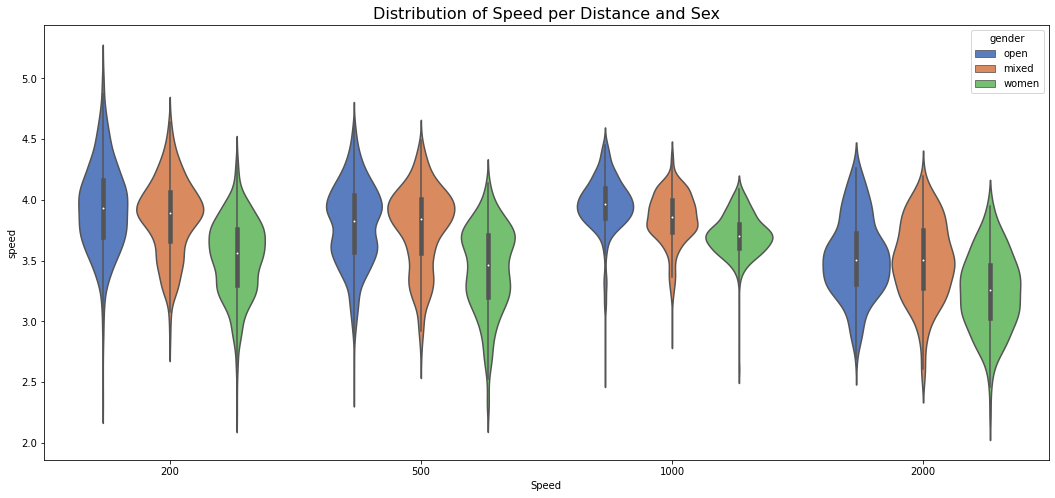

In [33]:
plt.figure(figsize=(18,8))
ax = sns.violinplot(x="distance", y="speed", hue="gender", data=data, palette="muted", order = ["200", "500", "1000", "2000"])
plt.title('Distribution of Speed per Distance and Sex', fontsize=16)
plt.xlabel('Speed');

## That's great, but what about medals?

In [36]:
data.head()

,venue,country,boat_type,distance,age_category,gender,race_number,lane_number,stage,new_result,speed
0,Thailand_2019,China,20,200,premier,open,275,3,grand final,00:39:251,5.095412
1,Thailand_2019,Thailand,20,200,premier,open,275,4,grand final,00:40:330,4.959088
2,Thailand_2019,China,20,200,premier,open,221,3,heat 1,00:41:047,4.872463
3,Thailand_2019,Canada,20,200,premier,open,275,2,grand final,00:41:253,4.848132
4,Thailand_2019,Thailand,20,200,premier,open,222,3,heat 2,00:41:648,4.802151


In [37]:
data['event_race'] = data['venue'] + data['race_number']

In [38]:
winners = data.groupby('event_race')['speed', 'country', 'stage'].transform('max')
winners = data.groupby('event_race').max()
winners['country'].nunique()

33

In [39]:
winners['country'].unique()

array(['United States of America', 'Philippines', 'Germany', 'Thailand',
       'Taiwan', 'Japan', 'Switzerland', 'Sweden', 'Great Britain',
       'Czech Republic', 'Macau', 'Spain', 'Singapore', 'Russia',
       'Ukraine', 'Iran', 'Hong Kong', 'China', 'Poland', 'India',
       'South Africa', 'Italy', 'Slovakia', 'Hungary',
       'Trinidad and Tobago', 'Puerto Rico', 'Romania', 'Canada',
       'Myanmar', 'New Zealand', 'South Korea', 'IDBF', 'Malaysia'],
      dtype=object)

Those were the winners of some race, at any stage of the event. But, let's find out who were the Golden Boys... which country actually raced a Final, Grand Final, Minor Final, and actually won the medal. 

In [40]:
# First, let's check out what categories we may be interested in.
# Apparently it's 'grand final', 'minor final', 'plate final', 'final', 'final 1'

data.stage.unique()

array(['grand final', 'heat 1', 'heat 2', 'round 2', 'round 1',
       'minor final', 'semi 2', 'semi 1', 'semi 3', 'heat 3', 'heat 4',
       'plate final', 'rep 1', 'rep 2', 'tail 2', 'tail 1', 'round 3',
       'final', 'final 1', 'semi', 'round 0', 'tail', 'round'],
      dtype=object)

In [41]:
gold_medals = winners[((winners.stage == 'final') | 
                        (winners.stage == 'grand final') | 
                        (winners.stage == 'minor final') | 
                        (winners.stage == 'plate final') | 
                        (winners.stage == 'final 1'))]

gold_medals['country'].unique()


array(['United States of America', 'Taiwan', 'Japan', 'Thailand',
       'Switzerland', 'Sweden', 'Macau', 'Spain', 'Ukraine', 'Hong Kong',
       'Singapore', 'Russia', 'Iran', 'Slovakia', 'Italy', 'Poland',
       'Germany', 'Hungary', 'Trinidad and Tobago', 'Canada', 'Romania',
       'Great Britain', 'Philippines', 'Czech Republic'], dtype=object)

### What???!

#### Where is China?

## Where is Spain in all this?

In [42]:
spain_data = data[data.country == 'Spain']
spain_data

,venue,country,boat_type,distance,age_category,gender,race_number,lane_number,stage,new_result,speed,event_race
320,Thailand_2019,Spain,20,200,premier,mixed,158,2,rep 2,00:52:579,3.803800,Thailand_2019158
323,Thailand_2019,Spain,20,200,premier,mixed,175,6,semi 2,00:52:603,3.802065,Thailand_2019175
353,Thailand_2019,Spain,20,200,premier,mixed,186,6,plate final,00:53:222,3.757845,Thailand_2019186
362,Thailand_2019,Spain,10,200,premier,open,271,2,tail 2,00:53:424,3.743636,Thailand_2019271
380,Thailand_2019,Spain,10,200,premier,open,238,1,rep 2,00:53:822,3.715953,Thailand_2019238
...,...,...,...,...,...,...,...,...,...,...,...,...
2576,China_2017,Spain,20,1000,premier,open,38,1,semi 1,04:27:075,3.744267,China_201738
2596,China_2017,Spain,20,1000,premier,open,45,1,minor final,04:32:165,3.674242,China_201745
2706,China_2017,Spain,10,2000,premier,open,11,2,final,10:49:358,3.079965,China_201711
2711,China_2017,Spain,10,2000,premier,mixed,3,3,final,10:56:893,3.044636,China_20173


In [43]:
spain_data['venue'].unique()

array(['Thailand_2019', 'China_2017'], dtype=object)

In [44]:
spain_data.groupby('distance')['speed'].max()


distance
1000    3.785499
200     3.803800
2000    3.362916
500     3.731037
Name: speed, dtype: float64

In [45]:
data.groupby('distance')['speed'].max()

distance
1000    4.466339
200     5.095412
2000    4.265120
500     4.637230
Name: speed, dtype: float64

In [46]:
spain_finals = spain_data[((spain_data.stage == 'final') | 
                        (spain_data.stage == 'grand final') | 
                        (spain_data.stage == 'minor final') | 
                        (spain_data.stage == 'plate final') | 
                        (spain_data.stage == 'final 1'))]

print(len(spain_finals))
spain_finals

19


,venue,country,boat_type,distance,age_category,gender,race_number,lane_number,stage,new_result,speed,event_race
353,Thailand_2019,Spain,20,200,premier,mixed,186,6,plate final,00:53:222,3.757845,Thailand_2019186
454,Thailand_2019,Spain,10,200,senior A,open,263,2,minor final,00:56:173,3.560429,Thailand_2019263
588,Thailand_2019,Spain,10,200,senior A,mixed,183,4,minor final,01:01:017,3.277775,Thailand_2019183
1085,Thailand_2019,Spain,10,500,premier,open,344,6,plate final,02:23:368,3.487529,Thailand_2019344
1153,Thailand_2019,Spain,10,500,senior A,open,355,2,minor final,02:28:083,3.376485,Thailand_2019355
1238,Thailand_2019,Spain,10,500,senior A,mixed,127,4,minor final,02:34:664,3.232814,Thailand_2019127
1706,Thailand_2019,Spain,20,2000,premier,mixed,6,11,final,09:54:722,3.362916,Thailand_20196
1746,Thailand_2019,Spain,10,2000,premier,open,17,9,final,10:18:671,3.232736,Thailand_201917
1751,Thailand_2019,Spain,10,2000,junior A,mixed,1,15,final,10:24:469,3.202721,Thailand_20191
1800,Thailand_2019,Spain,10,2000,senior A,open,11,2,final,11:21:214,2.935935,Thailand_201911


## Still lot of work ahead

- Get more data: Scrapping
- Analyse National Teams Vs Club Crew
- Clusterize?
- Find China...

**References:**

- https://medium.com/@larushkalmy/the-nerds-guide-to-triathlon-25e1daa90571
- https://medium.com/analytics-vidhya/how-i-used-data-science-skills-to-become-triathlon-athlete-c6e17c5c652c
- https://towardsdatascience.com/creating-a-simple-folium-map-covid-19-worldwide-total-case-a0a1429c6e7c
- https://www.kdnuggets.com/2018/09/visualising-geospatial-data-python-folium.html
- https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib